**Define all the imports**

In [ ]:
import os
import cv2
import numpy as np


import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard


from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.image import imread
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root_path = '../input/minneapple/detection/train'

Mounted at /content/drive


In [ ]:
dataset_url = "https://conservancy.umn.edu/bitstream/handle/11299/206575/counting.tar.gz?sequence=1&isAllowed=y"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='counting', 
                                   untar=True)

In [ ]:
# dataset_url = 'https://conservancy.umn.edu/bitstream/handle/11299/206575/detection.tar.gz?sequence=2&isAllowed=y'
# data_dir = tf.keras.utils.get_file(origin=dataset_url, 
#                                    fname='detection', 
#                                    untar=True)



1825398784/1825397590 [==============================] - 37s 0us/step


In [ ]:
os.listdir(data_dir +'/train')

['images', 'train_ground_truth.txt']

In [ ]:
import pandas as pd
labels_train = pd.read_csv(data_dir +'/train/train_ground_truth.txt')
labels_train = labels_train['count']

labels_val = pd.read_csv( data_dir +'/val/val_ground_truth.txt')
labels_val = labels_val['count']


# convert this 1D array to 2D array
train_labels = np.expand_dims(labels_train, axis=1)
val_labels = np.expand_dims(labels_val, axis=1)

In [ ]:
# train_labels = train_labels.tolist();

train_labels = np.expand_dims(labels_train, axis=1)
val_labels = np.expand_dims(labels_val, axis=1)

In [ ]:
train_labels = train_labels[0:64594]
val_labels = val_labels[0:900]

print(train_labels.size)
print(val_labels.size)

64594
900


In [ ]:
train_ds = np.empty([64594, 32, 32, 3], dtype=np.uint8)
val_ds = np.empty([900, 32, 32, 3], dtype=np.uint8)

In [ ]:
#List of train image

Train_img_Path =data_dir +'/train/images/';
from keras.preprocessing.image import img_to_array
for i in range (0,64594):

  image_name = Train_img_Path + 'images_' + "%05d" % i + '.png'
  
  image_i = Image.open(image_name)

  #resize image
  new_image = image_i.resize((32, 32))

  #conv array
  array_image = img_to_array(new_image)

  train_ds[i, :, :, :] = array_image

    

In [ ]:
# Load Validation Images
Val_img_Path =data_dir +'/val/images/';
for i in range (0,900):

  image_name = Val_img_Path + 'images_' + "%05d" % i + '.png'
  
  image_i = Image.open(image_name)

  #resize image
  new_image = image_i.resize((32, 32))

  #conv array
  array_image = img_to_array(new_image)

  val_ds[i, :, :, :] = array_image

Normalization 

In [ ]:
print(len(val_ds))
train_ds, val_ds = train_ds / 255.0, val_ds / 255.0

900


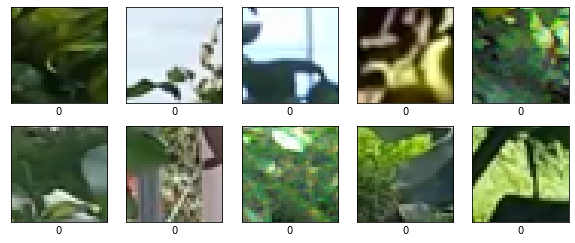

In [ ]:
class_names = ['0', '1']

plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_ds[i, :, :, :], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir +'/train/',
#   labels='inferred',
#   label_mode='int',
#   class_names=train_labels.all(),
#   validation_split=0.9,
#   subset="training",
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=32)




Found 64595 files belonging to 1 classes.
Using 6460 files for training.


In [ ]:
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir +'/val/',
#   validation_split=0.5,
#   subset="validation",
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

Found 3395 files belonging to 1 classes.
Using 1697 files for validation.


In [ ]:
class_names = train_ds.class_names
train_ds.interleave

<bound method DatasetV2.interleave of <BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>>

In [ ]:
# os.listdir(data_dir +'/train' )
# data_dir +'/..'


os.listdir('/root/.keras/datasets/')

['counting', 'counting.tar.gz']

In [ ]:
train_dataset.imgs[1]

'20150919_174151_image101.png'

**Training Using Basic CNN (VGG16)**

In [ ]:
num_classes = 2

model = tf.keras.Sequential([
  # layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(7)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
# model.summary()

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001) # choose an optimizer - no need to understand

# use some existing CNN architecture - VGG used here, with pre-trained weights
# remove the dense layers by "include_top" = False. We will add some dense layers
# ourselves later
base_model = keras.applications.VGG16(weights="imagenet", include_top=False)

# add a global average pooling layer to the convolutional based
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)

# add 1 neuron for the class label to the output layer.
# use sigmoid activation function to make this output a float value between 0 and 1
class_output = keras.layers.Dense(1, activation="sigmoid")(avg)

# combine the 5 neurons to make the output layer
model2 = keras.Model(inputs=base_model.input, outputs=[class_output])

# use binary cross entropy loss for class prediction and mse loss for bounding box
# regression
model2.compile(loss=["binary_crossentropy", "mse"], loss_weights=[0.8, 0.2], optimizer=opt, metrics=["accuracy"])

In [ ]:
model2.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [ ]:
# history = model.fit(train_ds, train_labels, epochs=7, 
#                     validation_data=(val_ds, val_labels)
#                     ,shuffle=True)

history = model.fit(train_ds, train_labels, epochs=5, validation_data=(val_ds, val_labels),shuffle=True)

Epoch 1/5
2019/2019 [==============================] - 7s 3ms/step - loss: 1.3322 - accuracy: 0.4637 - val_loss: 0.3103 - val_accuracy: 0.9022
Epoch 2/5
2019/2019 [==============================] - 6s 3ms/step - loss: 0.6393 - accuracy: 0.7642 - val_loss: 0.3525 - val_accuracy: 0.8878
Epoch 3/5
2019/2019 [==============================] - 6s 3ms/step - loss: 0.3946 - accuracy: 0.8580 - val_loss: 0.3400 - val_accuracy: 0.8722
Epoch 4/5
2019/2019 [==============================] - 6s 3ms/step - loss: 0.2977 - accuracy: 0.8926 - val_loss: 0.3900 - val_accuracy: 0.8656
Epoch 5/5
2019/2019 [==============================] - 6s 3ms/step - loss: 0.2271 - accuracy: 0.9197 - val_loss: 0.2653 - val_accuracy: 0.9078


In [ ]:
history2 = model2.fit(train_ds, train_labels, epochs=10, validation_data=(val_ds, val_labels),shuffle=True)

In [ ]:

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
 	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()
 
# summarize_diagnostics(history)

29/29 - 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00


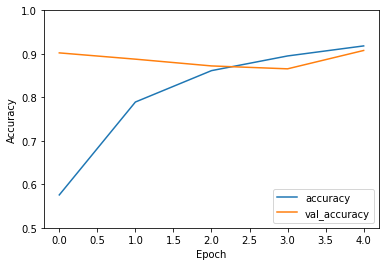

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(val_ds, verbose=2)

107/107 - 0s - loss: 0.5624 - accuracy: 0.7918


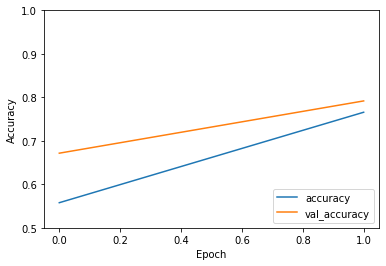

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(val_ds,  val_labels, verbose=2)

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_6 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)              

In [ ]:
model.save('AppleCounting_Basic_CNN.h5')

**Code Test**

In [ ]:
os.listdir(data_dir+ '/test/images/')

Apple Detection

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Number of apples predicted:
[1]
[[ -2.2533283   5.2437744   4.3971643   2.7523744   1.7910761  -2.1427588
  -12.9460535]]


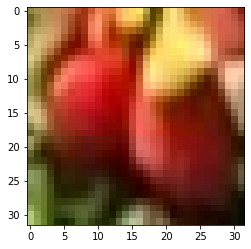

In [ ]:
from keras.models import load_model
#import cv2
import numpy as np

model = load_model('AppleCounting_Basic_CNN.h5')

#model.compile(optimizer='adam',
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #metrics=['accuracy'])

i = 3000
        
# Test_Path = data_dir+ '/test/images/testset1_775cluster_1.jpg';
        
# image_name = path_test + 'two_apple.jpg' #'images_' + "%05d" % i + '.png'

test_img = data_dir+ '/test/images/testset1_775cluster_1.jpg';
# 
# test_img = '/content/dataset1_front_661.png'
  
image_i = Image.open(test_img)  

plt.imshow(image_i)

  #resize image
new_image = image_i.resize((32, 32))

  #conv array
array_image = img_to_array(new_image)

#resize to 0-1
array_image = array_image / 255.0


img = np.expand_dims(array_image, axis=0)


 #img = np.reshape(img_to_array,[1,32,32,3])

plt.imshow(img[0, :, :, :], cmap=plt.cm.binary)

classes = model.predict_classes(img)
classe = model.predict(img)

print("Number of apples predicted:")
print(classes)
print(classe)

In [ ]:
test_img = '/content/dataset1_front_661.png'

  
image_abs = Image.open(test_img)

  #resize image
new_image = image_abs.resize((480, 352))

  #conv array
array_image = img_to_array(new_image)


#array_image = np.expand_dims(array_image, axis=0)

#print(array_image.shape)

In [ ]:
val_images = np.full((660,16,16,3), 0)


In [ ]:
k=0
im = image_abs
for i in range(0,464,16):
    for j in range(0,336,16):
        box = (j, i, j+16, i+16)
        a = im.crop(box)
        #o = a.crop(area)
        val_images[k,:,:,:] = a
        k = k + 1

In [ ]:
#resize to 0-1
val_images = val_images / 255.0

print(val_images.shape)

(660, 16, 16, 3)


In [ ]:
print(val_images[0,:,:,:].shape)
prediction_nb*0.5

(16, 16, 3)


array([[0.15431592]], dtype=float32)

Apple Counting Test

number of apples
8


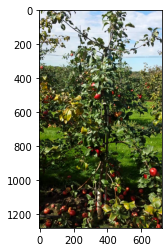

In [ ]:

from keras.models import load_model
import keras

model = load_model('VGGCnnModel.h5')
# model = load_model('AppleCounting_Basic_CNN.h5')

opt = keras.optimizers.Adam(learning_rate=0.0001) # choose an optimizer - no need to understand
model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[0.8, 0.2], optimizer=opt, metrics=["accuracy"])


tab_cut_images = np.resize(val_images,(660,32,32,3))


number_apple = 0

for i in range(0,656):
    
    image_i = tab_cut_images[i,:,:,:]
    
    image_i = np.expand_dims(image_i, axis=0)
    
    prediction_nb = model.predict(image_i)
    
    number_apple = number_apple + prediction_nb*0.5
    
number_apple = int(number_apple)    

plt.imshow(image_abs)
print("number of apples")
print(number_apple)